In [58]:
#### Acá importo todas las librerías que vaya a usar 
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling as pr
import numpy as np
import seaborn as sns
import re
import unicodedata
import time

%matplotlib inline
from matplotlib.gridspec import GridSpec
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [67]:
# FUNCIONES PARA CREAR PIPELINE DE MODELOS 
def create_dataset():
    """
    Function responsible for creating an empty DataFrame object with some of classification metrics
    
    Returns:
        empty DataFrame object
    """
    attributes = ['acc', 'prec', 'rec', 'f1', 'total_time']
    model_performance = pd.DataFrame({})
    for col in attributes:
        model_performance[col] = []
        
    return model_performance

def model_analysis(model, X, y, X_test, y_test, df_performance, cv=5, train=True):
    """
    Function responsible for evaluate a classification model and save the results on a DataFrame object
    
    Input:
        model: model to be used on evaluation
        X, y, X_test, y_test: train and test data (with target labels)
        df_performance: empty DataFrame (generated by create_dataset() function)
        cv: cross validation k folds

    Returns:
        a DataFrame object with classification metrics selected
    """
    # Accuracy, precision, recall and f1_score on training set using cv
    t0_cv = time.time()
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    prec = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
    rec = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    # Time spent on cross_validation prediction
    t1_cv = time.time()
    delta_time_cv = t1_cv-t0_cv
    
    # Evaluation using the test set
    t0_test = time.time()
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test)
    rec_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    y_scores_test = model.predict_proba(X_test)[:, 1]
    # Time spent on test prediction
    t1_test = time.time()
    delta_time_test = t1_test-t0_test

    # Saving on dataframe
    performances = {}
    performances['acc'] = round(acc, 4)
    performances['prec'] = round(prec, 4)
    performances['rec'] = round(rec, 4)
    performances['f1'] = round(f1, 4)
    performances['total_time'] = round(delta_time_cv, 3)        
    df_performance = df_performance.append(performances, ignore_index=True)
    
    test_performances = {}
    test_performances['acc'] = round(acc_test, 4)
    test_performances['prec'] = round(prec_test, 4)
    test_performances['rec'] = round(rec_test, 4)
    test_performances['f1'] = round(f1_test, 4)
    test_performances['total_time'] = round(delta_time_test, 3)        
    df_performance = df_performance.append(test_performances, ignore_index=True)
    
    model_name = model.__class__.__name__
    df_performance.index = [model_name+' cv', model_name+' test']
    
    return df_performance

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots a customized confusion matrix
    
    Input:
        cm: confusion matrix generated from sklearn's method confusion_matrix(set, predictions)
        classes: target labels to be plotted
        title: title
        cmap: matrix color
    Output:
        None
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Plot configuration
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def style_function(feature):
    """
    Customize maps
    """
    return {
        'fillColor': '#ffaf00',
        'color': 'grey',
        'weight': 1.5,
        'dashArray': '5, 5'
    }

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots a customized confusion matrix
    
    Input:
        cm: confusion matrix generated from sklearn's method confusion_matrix(set, predictions)
        classes: target labels to be plotted
        title: title
        cmap: matrix color
    Output:
        None
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Plot configuration
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
url = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/rain_data_aus.csv'

w1 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_01.csv'
w2 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_02.csv'
w3 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_03.csv'
w4 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_04.csv'
w5 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_05.csv'
w6 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_06.csv'
w7 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_07.csv'
w8 = 'https://raw.githubusercontent.com/brunopauka/processo_cientista/master/data/wind_table_08.csv'
                    

data = pd.read_csv(url,sep=",") 
data_w1 = pd.read_csv(w1,sep=",")
data_w2 = pd.read_csv(w2,sep=",")
data_w3 = pd.read_csv(w3,sep=",") 
data_w4 = pd.read_csv(w4,sep=",") 
data_w5 = pd.read_csv(w5,sep=",") 
data_w6 = pd.read_csv(w6,sep=",") 
data_w7 = pd.read_csv(w7,sep=",") 
data_w8 = pd.read_csv(w8,sep=",") 

In [6]:
#data.sort_values("raintoday", inplace = True)
#data = data.drop(columns=['modelo_vigente'],axis=1)
data['raintoday']=data['raintoday'].replace({'No': 0, 'Yes': 1})
data['raintomorrow']=data['raintomorrow'].replace({'No': 0, 'Yes': 1})

In [7]:
cols=['date', 'location', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm']
data_w1.columns = cols
data_w2.columns = cols

In [8]:
frames = [data_w1,data_w2,data_w3,data_w4,data_w5,data_w6,data_w7,data_w8]
data_w = pd.concat(frames, sort=False)

In [9]:
# Joining order and items datasets
db_model = data.merge(data_w, on=['date','location'], how='left')


In [10]:
# Vars
db_model['month']=db_model['date'].str.slice(start=5, stop=7)
db_model['month_day']=db_model['date'].str.slice(start=5, stop=10)


In [11]:
X=db_model.drop(['raintomorrow','date','modelo_vigente'],axis=1)
y = db_model['raintomorrow'].values
Y_tf = y.astype(int)

In [12]:
# Reviso si hay valores nulos en las variables categoricas
categorical=[var for var in X.columns if X[var].dtype=='object']
X[categorical].isnull().sum()

location           0
windgustdir    10578
winddir9am     11428
winddir3pm      4835
month              0
month_day          0
dtype: int64

In [13]:
# Se crean variables dummy de las categoricas para facilidad de uso en los modelos posteriormente
X_d=pd.get_dummies(X)


In [14]:
# Se elimina una de las dummies de cada variable que tenia 0 missings
# Para las otras no es necesario porque está la categría de missing
X_d=X_d.drop(['location_Woomera','month_12','month_day_12-31'],axis=1)
cols = list(X_d.columns)

In [15]:
# Arreglo los valores null con la mediana porque es más robusta que la media para frente a valores extremos.
X_d = X_d.fillna(X_d.median())

In [16]:
######## AQUI COMIENZA LA PARTE DE FEATURE EXTRACTION

In [17]:
# División en train y test para validación de resultados y control de overfitting
X_train, X_test, y_train, y_test = train_test_split(X_d, Y_tf, test_size = 3/10, random_state = 9)

In [18]:
# RF
clf = RandomForestClassifier(n_estimators=100,criterion="gini",max_depth=5, random_state=9)
#Revisar numero de hojas después así como: max_features=sqrt(n_features)


In [19]:
# Treino 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

In [20]:
# Predicao
y_pred = clf.predict(X_test)

In [21]:
# Resultados parecidos com o modelo com modelo
score = clf.score(X_test, y_test)
print(score)

0.8620731608402953


In [22]:
# Evaluating results
empty_train_performance = create_dataset()
rf_performance = model_analysis(clf, X_train, y_train, X_test, y_test,empty_train_performance)
rf_performance

,acc,prec,rec,f1,total_time
RandomForestClassifier cv,0.8611,0.9995,0.3867,0.5572,636.106
RandomForestClassifier test,0.8621,0.9995,0.3818,0.5525,7.816


<IPython.core.display.Javascript object>


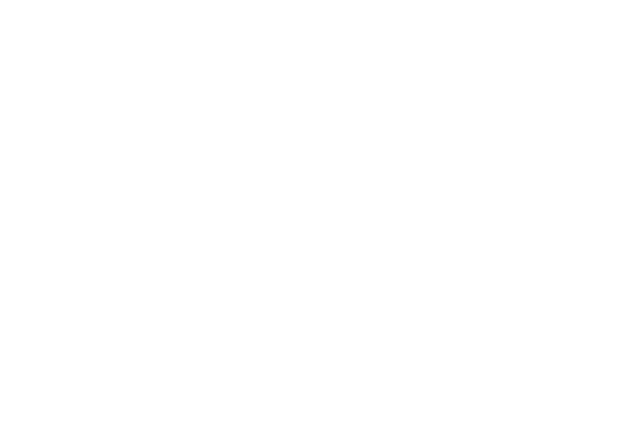

In [54]:
# ROC RF
%matplotlib notebook
rf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [24]:
# Extracao de features
feature_imp = pd.Series(clf.feature_importances_,index=cols).sort_values(ascending=False)
#feature_imp

<IPython.core.display.Javascript object>


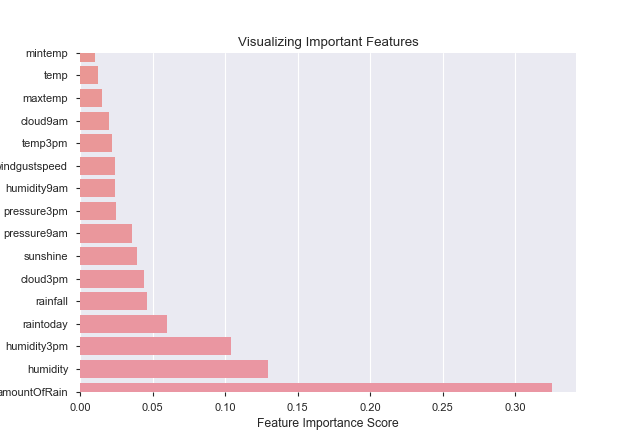

No handles with labels found to put in legend.


In [53]:
# Creating a bar plot
%matplotlib notebook
sns.barplot(x=feature_imp, y=feature_imp.index)
# control x and y limits
plt.ylim(0, 15)
plt.xlim(0, None)


# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [26]:
vars_usar=feature_imp.index[0:20]
vars_usar

Index(['amountOfRain', 'humidity', 'humidity3pm', 'raintoday', 'rainfall',
       'cloud3pm', 'sunshine', 'pressure9am', 'pressure3pm', 'humidity9am',
       'windgustspeed', 'temp3pm', 'cloud9am', 'maxtemp', 'temp', 'mintemp',
       'evaporation', 'windspeed3pm', 'windspeed9am', 'temp9am'],
      dtype='object')

In [27]:
X_new=X_d[vars_usar]


<IPython.core.display.Javascript object>


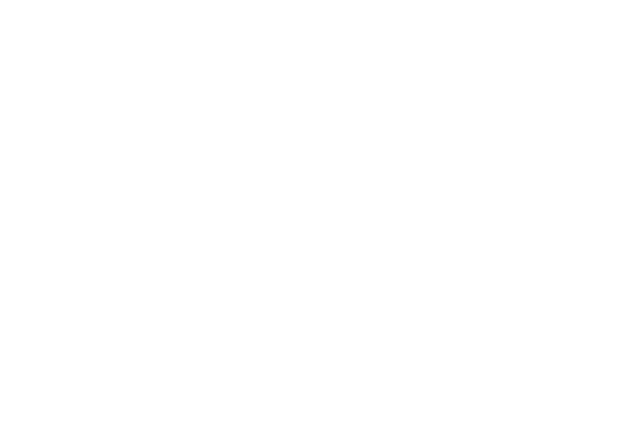

<IPython.core.display.Javascript object>


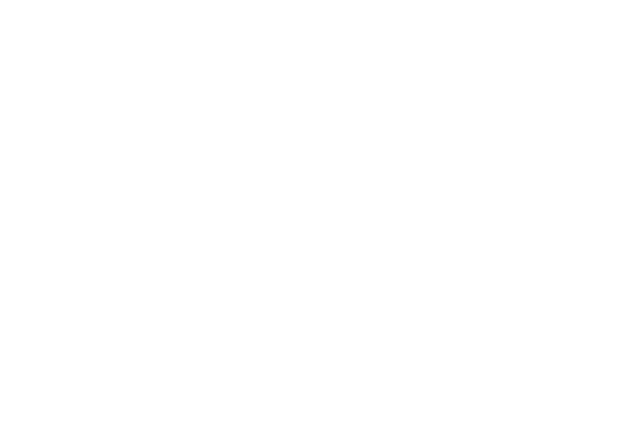

Number of variables,20
Number of observations,164386
Total Missing (%),0.0%
Total size in memory,26.3 MiB
Average record size in memory,168.0 B
Numeric,16
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,3


In [28]:
pr.ProfileReport(X_new)

In [30]:
# Elimino as variaveis que tem correlacao 
X_train=X_train[vars_usar]
X_train=X_train.drop(['humidity','pressure9am', 'temp3pm'],axis=1)

X_test=X_test[vars_usar]
X_test=X_test.drop(['humidity','pressure9am', 'temp3pm'],axis=1)

In [31]:
X_test.shape

(49316, 17)

In [32]:
# Gradient boosting
gbrt=GradientBoostingClassifier(random_state=9)
gbrt.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=9, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [33]:
# Evaluating results GB
empty_train_performance = create_dataset()
gbc_performance = model_analysis(gbrt, X_train, y_train, X_test, y_test,empty_train_performance)
gbc_performance

,acc,prec,rec,f1,total_time
GradientBoostingClassifier cv,1.0,1.0,1.0,1.0,296.596
GradientBoostingClassifier test,1.0,1.0,1.0,1.0,0.696


<IPython.core.display.Javascript object>


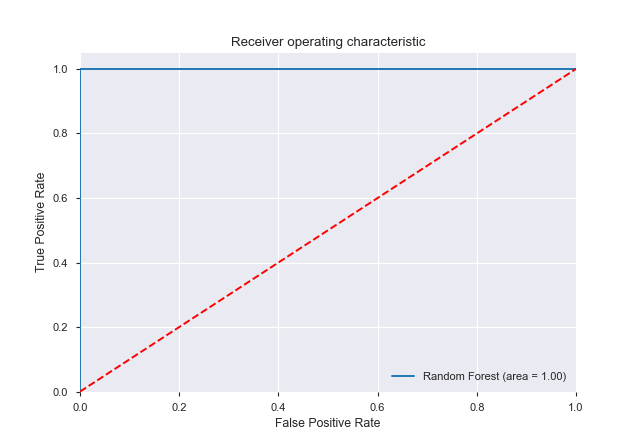

In [34]:
# ROC GBC
gbc_roc_auc = roc_auc_score(y_test, gbrt.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gbrt.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % gbc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [45]:
# Reg Log
# Training a Logistic Regression model
logreg_model = LogisticRegression( random_state=9)
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
score = logreg_model.score(X_test, y_test)
print(score)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9999797226052397


In [46]:
# Evaluating results RLog
empty_train_performance = create_dataset()
log_reg_performance = model_analysis(logreg_model, X_train, y_train, X_test, y_test,empty_train_performance)
log_reg_performance

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

,acc,prec,rec,f1,total_time
LogisticRegression cv,0.9999,1.0,0.9997,0.9998,118.871
LogisticRegression test,1.0000,1.0,0.9999,1.0000,0.290


<IPython.core.display.Javascript object>


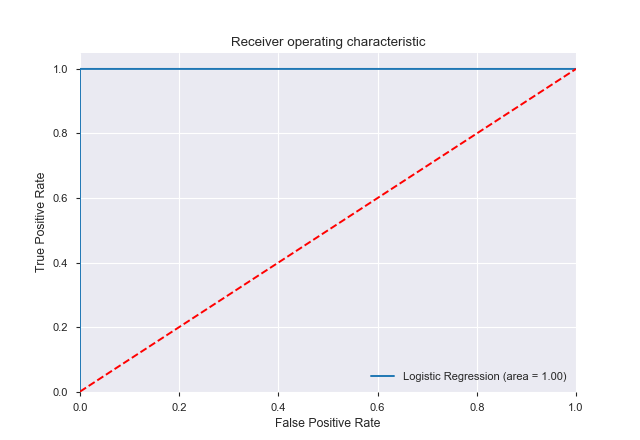

In [47]:
# ROC RLog
logit_roc_auc = roc_auc_score(y_test, logreg_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [48]:
# RF
clf = RandomForestClassifier(n_estimators=100,criterion="gini",max_depth=5, random_state=9)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
empty_train_performance = create_dataset()
rf_performance = model_analysis(clf, X_train, y_train, X_test, y_test,empty_train_performance)
rf_performance

,acc,prec,rec,f1,total_time
RandomForestClassifier cv,1.0,1.0,1.0,1.0,374.119
RandomForestClassifier test,1.0,1.0,1.0,1.0,3.081


<IPython.core.display.Javascript object>


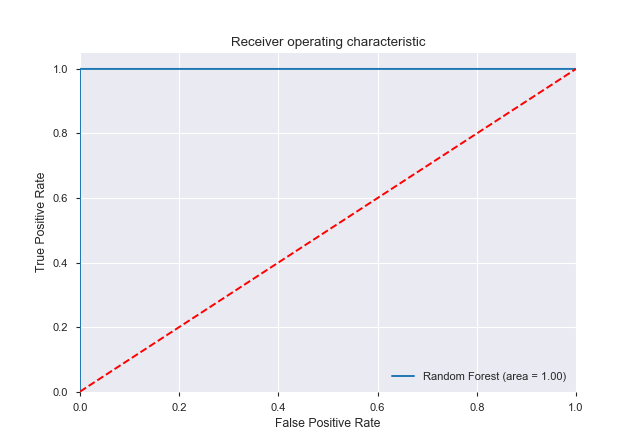

In [49]:
# Crio curva ROC o modelo de RF
rf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [50]:
# logit
logit_roc_auc

0.9999545413219384

In [39]:
# XGB
gbc_roc_auc

1.0

In [42]:
# RF
rf_roc_auc

1.0

In [43]:
# Levando em conta a performance dos modelos, é possível usar a regressao logistica e a vantagem é que é facil de 
# explicar. Com esse vai ser determinado o ponto de corto para escorar a base de teste 

In [44]:
# encontra a posição do ponto que miniza a distância entre (0,1) e (FPR,TPR)
fpr, tpr, thresholds = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])
opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
tpr[opt_idx] # TPR do ponto que minimiza a distância
fpr[opt_idx] # FPR do ponto que minimiza a distância
thresholds[opt_idx]  # Score do ponto que minimiza a distância

0.44147932605088164

In [52]:
# Valido meu resultado final
#Y_tf
X_final=X_d[vars_usar]
X_final=X_final.drop(['humidity','pressure9am', 'temp3pm'],axis=1)

y_pred = logreg_model.predict(X_final)

In [65]:
df = DataFrame(y_pred,columns=['Vai_chover'])
df.head()

,Vai_chover
0,0
1,0
2,0
3,0
4,0


In [66]:
df['final'] = df['Vai_chover'].apply(lambda x: 0 if x < thresholds[opt_idx] else 1)

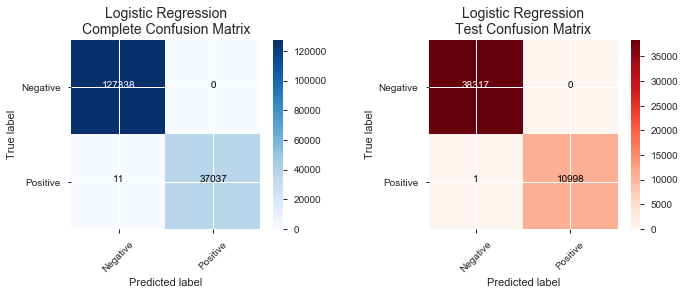

In [71]:
# Confusion matrix

y_pred = logreg_model.predict(X_test)
df_y = DataFrame(y_pred,columns=['Vai_chover'])
test_pred = df_y['Vai_chover'].apply(lambda x: 0 if x < thresholds[opt_idx] else 1)


# Confusion matrix
cv_cm = confusion_matrix(Y_tf, df['final'])
test_cm = confusion_matrix(y_test, test_pred)

# Plotting
fig = plt.figure(figsize=(10, 4))
classes = ['Negative','Positive']
plt.subplot(121)
plot_confusion_matrix(cv_cm, classes, title='Logistic Regression\nComplete Confusion Matrix')
plt.subplot(122)
plot_confusion_matrix(test_cm, classes, cmap=plt.cm.Reds, title='Logistic Regression\nTest Confusion Matrix')

plt.tight_layout()
plt.show()


In [72]:
# E possivel observar que se tem uma predicao quase perfeita da chuva, os passos a seguir poderia ser efetuar modelos
# com menos variaveis procurando uma predicao tao boa quanto o modelo feito. 

In [76]:
print(pd.__version__)

0.24.2
